In [1]:
import os
from keras import Model
from keras.optimizers import Adam
from keras.applications.densenet import DenseNet201, preprocess_input
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from livelossplot.inputs.keras import PlotLossesCallback
from pathlib import Path
import numpy as n

2025-01-17 14:21:27.464658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-17 14:21:27.569185: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 14:21:28.049345: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-01-17 14:21:28.049394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

## Analise dos dados

In [2]:
path = "../../data/treino"
pathTest = "../../data/teste"


def listdir(dir):
    filenames = os.listdir(dir)
    
    total = 0
    for files in filenames:
        count = 0
        file_path = os.path.join(dir, files)
        for file in os.listdir(file_path):
            count += 1
        print(files + ": " + str(count))
        total += count

    print(total)
    
print("Para Treino")
listdir(path)
print("Para Teste")
listdir(pathTest)

Para Treino
P-70: 57
P17: 163
P-21: 64
P-13: 23
P-1: 154
P-19: 94
P-62: 86
P-08: 32
P-3: 41
P-09: 66
P-22: 94
P-04: 17
P-16: 65
P-69_: 22
P-01: 13
P-11: 173
1164
Para Teste
P-70: 18
P17: 54
P-21: 21
P-13: 8
P-1: 51
P-19: 31
P-62: 28
P-08: 11
P-3: 13
P-09: 22
P-22: 31
P-04: 5
P-16: 21
P-69_: 7
P-01: 4
P-11: 64
389


In [3]:

BATCH_SIZE = 64

train_generator = ImageDataGenerator(
                                    rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.15,
                                    preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [4]:
class_subset = sorted(os.listdir('../../data/imagens'))
training =  train_generator.flow_from_directory(directory='../../data/treino',
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validation = train_generator.flow_from_directory('../../data/treino',
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testing = test_generator.flow_from_directory('../../data/teste',
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 997 images belonging to 16 classes.
Found 166 images belonging to 16 classes.
Found 389 images belonging to 16 classes.


In [5]:
class_subset

['P-01',
 'P-04',
 'P-08',
 'P-09',
 'P-1',
 'P-11',
 'P-13',
 'P-16',
 'P-19',
 'P-21',
 'P-22',
 'P-3',
 'P-62',
 'P-69_',
 'P-70',
 'P17']

In [6]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = DenseNet201(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        classifier_activation="softmax",
    )


    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    print(model.summary())

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [7]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes= len(class_subset)

n_steps = training.samples // BATCH_SIZE
n_val_steps = validation.samples // BATCH_SIZE
n_epochs = 50

In [8]:


plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='../../weights/DenseNet201_v1.weights.best.keras',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [9]:

# Use a smaller learning rate
optim_2 = Adam(learning_rate=0.0001)

# Just Feature Extraction
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

2025-01-17 14:21:29.099099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-17 14:21:29.126184: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-17 14:21:29.126349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-17 14:21:29.126663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

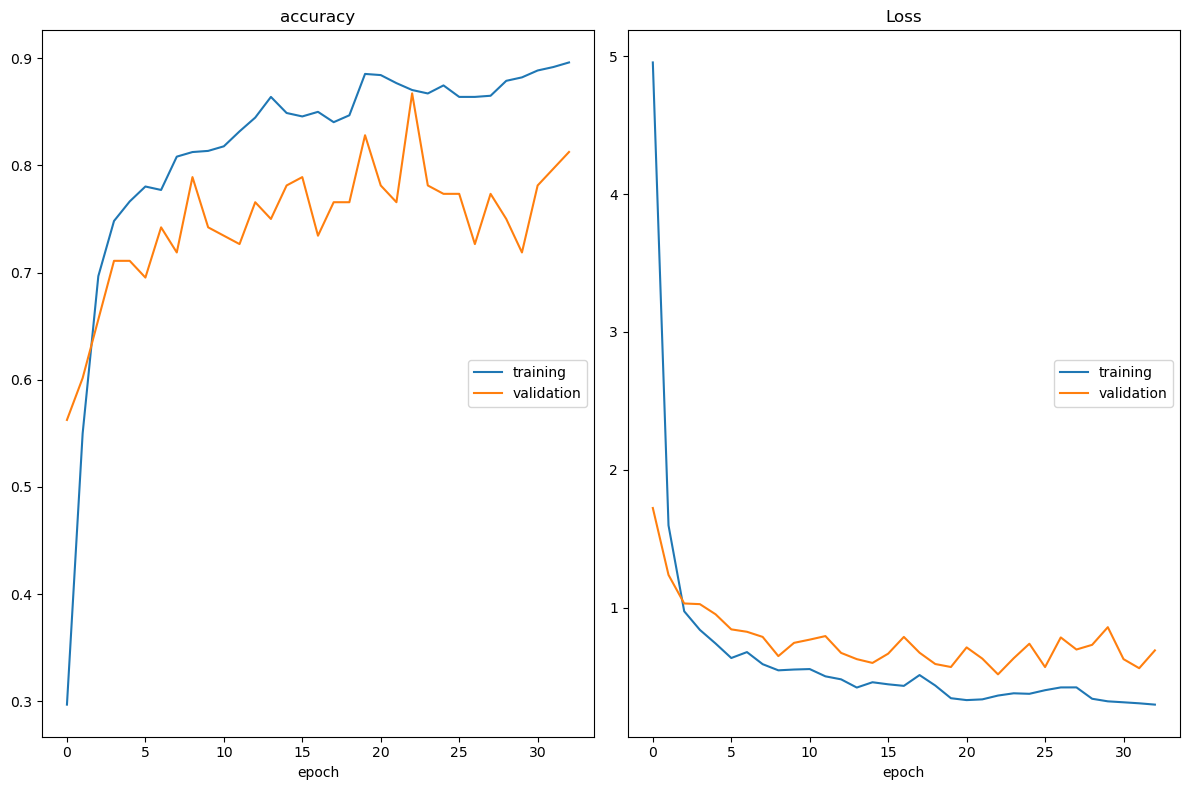

accuracy
	training         	 (min:    0.297, max:    0.896, cur:    0.896)
	validation       	 (min:    0.562, max:    0.867, cur:    0.812)
Loss
	training         	 (min:    0.298, max:    4.954, cur:    0.298)
	validation       	 (min:    0.517, max:    1.723, cur:    0.691)
15/15 [==============================] - 10s 657ms/step - loss: 0.2975 - accuracy: 0.8960 - val_loss: 0.6908 - val_accuracy: 0.8125
CPU times: user 5min 49s, sys: 1min 21s, total: 7min 11s
Wall time: 6min 39s


In [10]:
%%time

plot_loss_2 = PlotLossesCallback()


# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(training,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validation,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [11]:

# Loading predictions from last article's model
from sklearn.metrics import accuracy_score

true_classes = testing.classes
# Generate predictions
vgg_model_ft.load_weights('../../weights/DenseNet201_v1.weights.best.keras') # initialize the best trained weights

vgg_preds_ft = vgg_model_ft.predict(testing)
vgg_pred_classes_ft = n.argmax(vgg_preds_ft, axis=1)
vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))


389/389 [==============================] - 8s 15ms/step
VGG16 Model Accuracy with Fine-Tuning: 87.66%


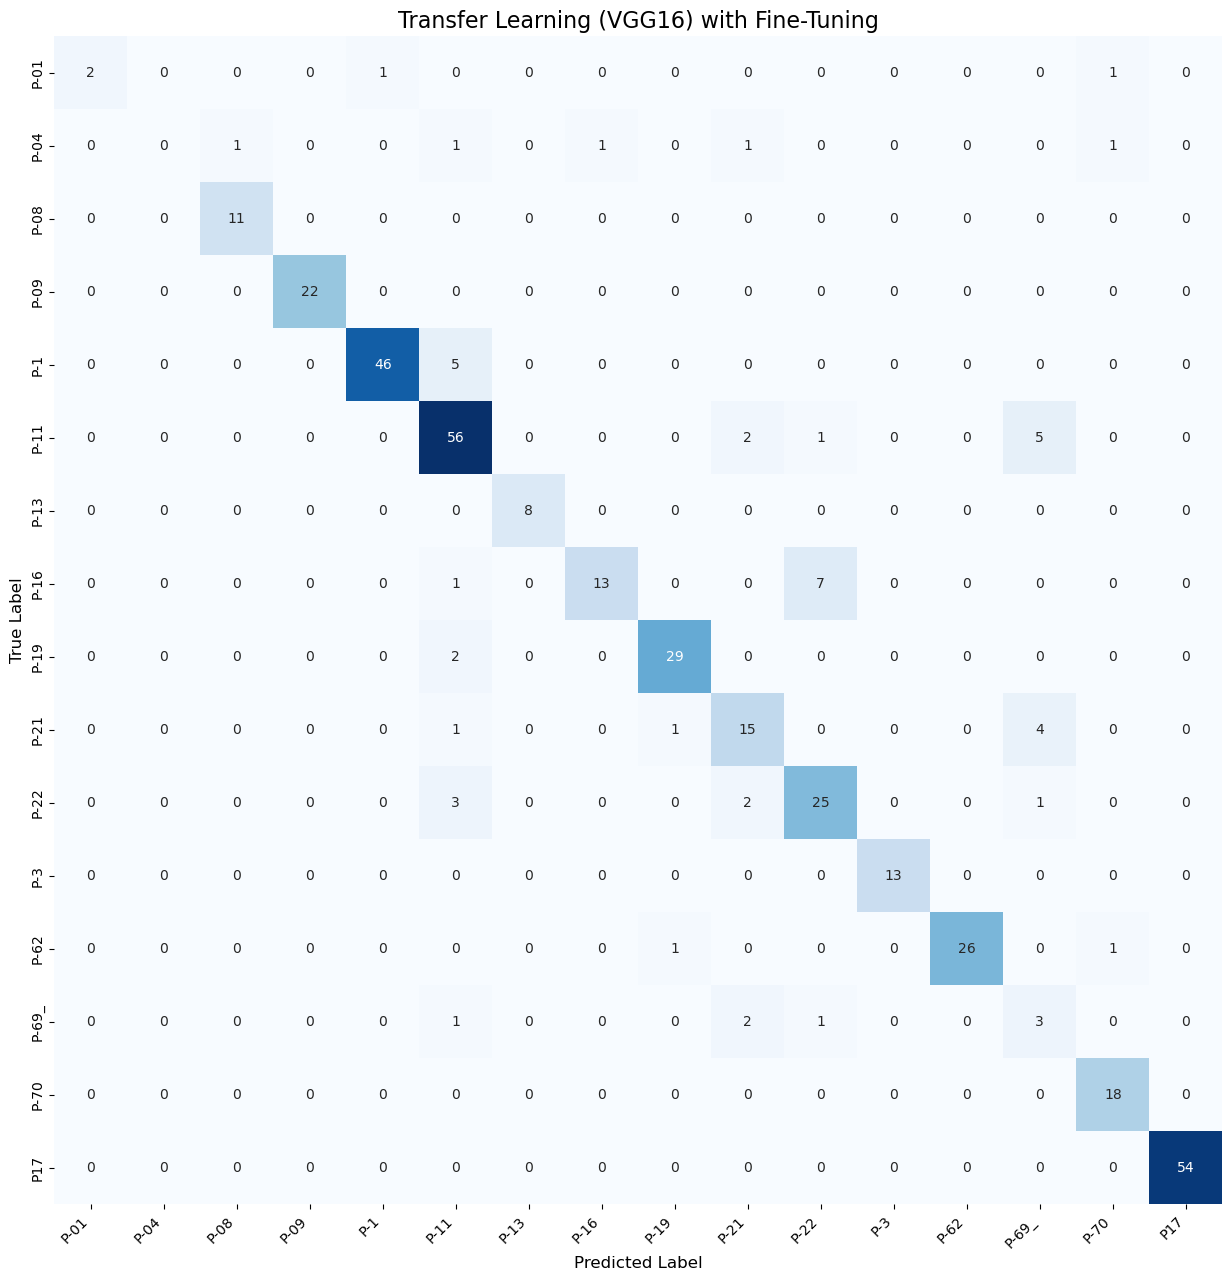

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt



# Get the names of the ten classes
class_names = testing.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(figsize=(20, 10))

plot_heatmap(true_classes, vgg_pred_classes_ft, class_names, ax, title="Transfer Learning (VGG16) with Fine-Tuning")


fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()
